/home/leon/Documentos/UNSA/IA/articulo-ia/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


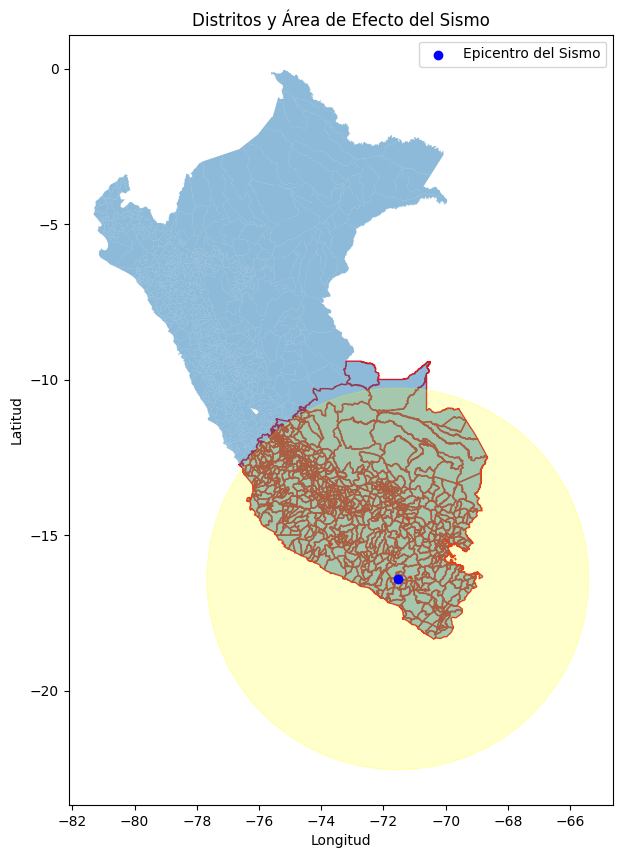

      NOMBDIST    NOMBPROV   NOMBDEP  Distancia al Epicentro (km)  POBLACION
14  YANAQUIHUA  CONDESUYOS  AREQUIPA                   177.760117     4415.0
15   MACHAGUAY    CASTILLA  AREQUIPA                   134.137214      564.0
16   ORCOPAMPA    CASTILLA  AREQUIPA                   162.096565     8906.0
17  PAMPACOLCA    CASTILLA  AREQUIPA                   141.673015     2269.0
18       URACA    CASTILLA  AREQUIPA                   106.838152     7199.0


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Point
from geopy.distance import geodesic

# 1. Cargar el archivo CSV
df = pd.read_csv('poblacion.csv', sep=';')

# 2. Crear una función para convertir GeoJSON a geometría Shapely
def convert_geojson_to_geometry(geojson_string):
    return shape(eval(geojson_string))

# 3. Aplicar la función para convertir GeoJSON a geometrías Shapely y crear un GeoDataFrame
df['geometry'] = df['Geo Shape'].apply(convert_geojson_to_geometry)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 4. Definir el epicentro del sismo (ejemplo)
epicentro_lat = -16.409047
epicentro_lon = -71.537451

epicentro = Point(epicentro_lon, epicentro_lat)

# 5. Calcular el radio de impacto del sismo (ejemplo)
magnitud_momento = 6.9
profundidad = 33 
R_km = 10 ** (0.5 * magnitud_momento) * ( 10 / (profundidad + 10)) # Radio en kilómetros

# Convertir el radio de km a grados de longitud y latitud
R_deg_lon = R_km / (111.32 * np.cos(np.radians(epicentro_lat)))  # Longitud
R_deg_lat = R_km / 110.574  # Latitud

# 6. Crear un buffer circular alrededor del epicentro del sismo
area_de_efecto = epicentro.buffer(R_deg_lon)

# 7. Intersectar el área de efecto con los distritos en el GeoDataFrame
distritos_en_area_efecto = gdf[gdf['geometry'].intersects(area_de_efecto)]

# 8. Calcular la distancia geodésica desde el epicentro a cada distrito afectado
def calcular_distancia(geometry, epicentro):
    centroide_distrito = geometry.centroid
    distancia = geodesic((epicentro.y, epicentro.x), (centroide_distrito.y, centroide_distrito.x)).kilometers
    return distancia

distritos_en_area_efecto['Distancia al Epicentro (km)'] = distritos_en_area_efecto['geometry'].apply(lambda geom: calcular_distancia(geom, epicentro))

# 9. Visualizar el resultado
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plotear los distritos que intersectan con el área de efecto
distritos_en_area_efecto.plot(ax=ax, edgecolor='red', facecolor='none')

# Plotear todos los distritos en transparencia
gdf.plot(ax=ax, alpha=0.5)

# Plotear el área de efecto del sismo
x, y = area_de_efecto.exterior.xy
ax.fill(x, y, alpha=0.2, color='yellow')

# Plotear el epicentro del sismo
ax.scatter(epicentro_lon, epicentro_lat, color='blue', label='Epicentro del Sismo', zorder=5)

# Configuración adicional del gráfico
ax.set_title('Distritos y Área de Efecto del Sismo')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()

# Guardar la figura como archivo PNG
plt.savefig('distritos_area_efecto_sismo.png', dpi=300)

# Mostrar el gráfico
plt.show()

# Mostrar las primeras filas para verificar
print(distritos_en_area_efecto[['NOMBDIST', 'NOMBPROV', 'NOMBDEP', 'Distancia al Epicentro (km)', 'POBLACION']].head())


In [2]:
print(f'R_km: {R_km} ')

R_km: 655.4378909917336 


In [3]:
distritos_en_area_efecto.columns

Index(['Geo Point', 'Geo Shape', 'CCDD', 'NOMBDEP', 'CCPP', 'NOMBPROV', 'CCDI',
       'NOMBDIST', 'CAPITAL', 'UBIGEO', 'IDPROV', 'CODIGO', 'CNT_CCPP',
       'DESCRIPCIO', 'POBLACION', 'FECHA', 'DAT_POB', 'geometry',
       'Distancia al Epicentro (km)'],
      dtype='object')

In [73]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Supongamos que R_km es tu radio en kilómetros

# Definición de las variables lingüísticas
magnitud = ctrl.Antecedent(np.arange(0, 10.1, 0.1), 'magnitud')
profundidad = ctrl.Antecedent(np.arange(0, 700.1, 1), 'profundidad')
poblacion = ctrl.Antecedent(np.arange(0, 3000000.1, 1000), 'poblacion')
riesgo = ctrl.Consequent(np.arange(0, 101, 1), 'riesgo')

# Definición de los conjuntos difusos para magnitud usando función gaussiana
magnitud['baja'] = fuzz.gaussmf(magnitud.universe, 3, 0.5)
magnitud['moderada'] = fuzz.gaussmf(magnitud.universe, 5, 0.5)
magnitud['alta'] = fuzz.gaussmf(magnitud.universe, 7, 0.5)

# Definición de los conjuntos difusos para profundidad usando función trapezoidal
profundidad['superficial'] = fuzz.trapmf(profundidad.universe, [0, 20, 35, 50])
profundidad['intermedia'] = fuzz.trapmf(profundidad.universe, [40, 70, 100, 140])
profundidad['profunda'] = fuzz.trapmf(profundidad.universe, [120, 170, 250, 700])

limite_cerca = [0, R_km / 10, R_km / 5]  # Rangos más pequeños para cerca
limite_media = [R_km / 6, R_km * 2 / 3, R_km]
limite_lejos = [R_km * 0.75, R_km * 1.5, R_km * 2]

distancia = ctrl.Antecedent(np.arange(0, R_km * 2 + 1, 1), 'distancia')
distancia['cerca'] = fuzz.trimf(distancia.universe, limite_cerca)
distancia['media'] = fuzz.trimf(distancia.universe, limite_media)
distancia['lejos'] = fuzz.trimf(distancia.universe, limite_lejos)

# Definición de los conjuntos difusos para población usando función trapezoidal
poblacion['baja'] = fuzz.trapmf(poblacion.universe, [0, 2000, 6500, 10000])
poblacion['media'] = fuzz.trapmf(poblacion.universe, [8000, 20000, 50000, 130000])
poblacion['alta'] = fuzz.trapmf(poblacion.universe, [120000, 300000, 1000000, 3000000])

# Definición de los conjuntos difusos para riesgo usando función trapezoidal
riesgo['bajo'] = fuzz.trapmf(riesgo.universe, [0, 0, 20, 40])
riesgo['medio'] = fuzz.trapmf(riesgo.universe, [30, 50, 70, 90])
riesgo['alto'] = fuzz.trapmf(riesgo.universe, [60, 80, 100, 100])


In [42]:
R_km

655.4378909917336

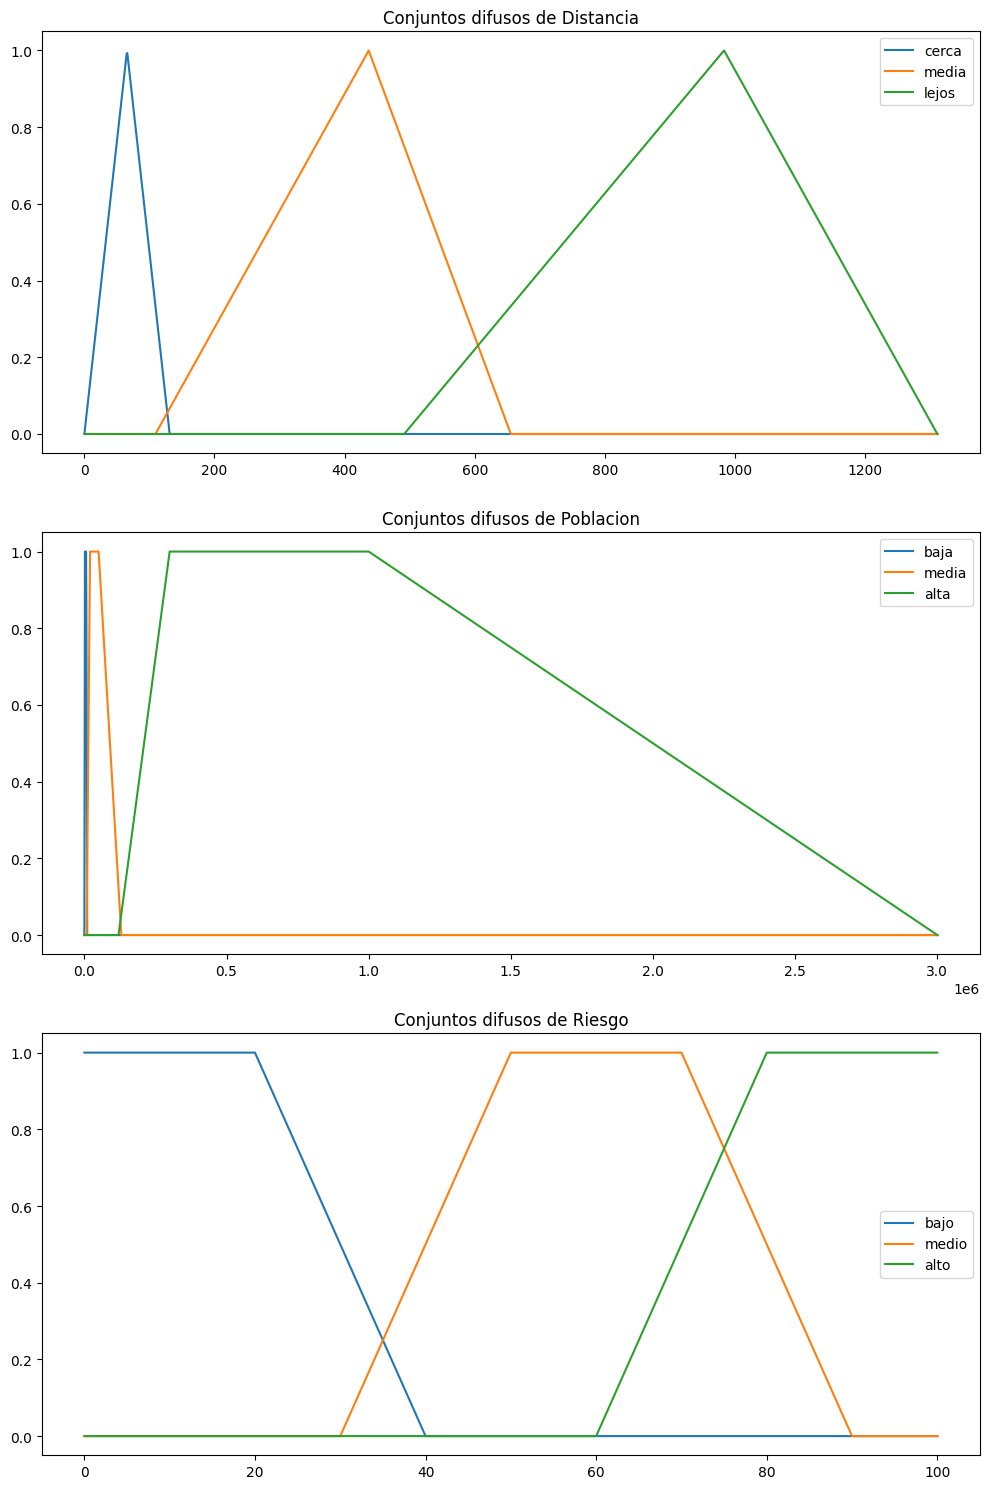

In [75]:
# Graficar los conjuntos difusos
variables = [magnitud, profundidad, distancia, poblacion, riesgo]
nombres = ['Magnitud', 'Profundidad', 'Distancia', 'Poblacion', 'Riesgo']

fig, axs = plt.subplots(len(variables), figsize=(10, 15))

for i, (variable, nombre) in enumerate(zip(variables, nombres)):
    for conjunto in variable.terms:
        axs[i].plot(variable.universe, variable[conjunto].mf, label=conjunto)
    axs[i].set_title(f'Conjuntos difusos de {nombre}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [76]:
# Definir las reglas
reglas = []

# Combinaciones de magnitud, profundidad, distancia y poblacion para definir el riesgo
combinaciones = [
    ('baja', 'superficial', 'cerca', 'baja', 'bajo'),
    ('baja', 'superficial', 'cerca', 'media', 'bajo'),
    ('baja', 'superficial', 'cerca', 'alta', 'medio'),
    ('baja', 'superficial', 'media', 'baja', 'bajo'),
    ('baja', 'superficial', 'media', 'media', 'bajo'),
    ('baja', 'superficial', 'media', 'alta', 'medio'),
    ('baja', 'superficial', 'lejos', 'baja', 'bajo'),
    ('baja', 'superficial', 'lejos', 'media', 'bajo'),
    ('baja', 'superficial', 'lejos', 'alta', 'bajo'),

    ('baja', 'intermedia', 'cerca', 'baja', 'bajo'),
    ('baja', 'intermedia', 'cerca', 'media', 'bajo'),
    ('baja', 'intermedia', 'cerca', 'alta', 'medio'),
    ('baja', 'intermedia', 'media', 'baja', 'bajo'),
    ('baja', 'intermedia', 'media', 'media', 'bajo'),
    ('baja', 'intermedia', 'media', 'alta', 'medio'),
    ('baja', 'intermedia', 'lejos', 'baja', 'bajo'),
    ('baja', 'intermedia', 'lejos', 'media', 'bajo'),
    ('baja', 'intermedia', 'lejos', 'alta', 'bajo'),

    ('baja', 'profunda', 'cerca', 'baja', 'bajo'),
    ('baja', 'profunda', 'cerca', 'media', 'bajo'),
    ('baja', 'profunda', 'cerca', 'alta', 'medio'),
    ('baja', 'profunda', 'media', 'baja', 'bajo'),
    ('baja', 'profunda', 'media', 'media', 'bajo'),
    ('baja', 'profunda', 'media', 'alta', 'medio'),
    ('baja', 'profunda', 'lejos', 'baja', 'bajo'),
    ('baja', 'profunda', 'lejos', 'media', 'bajo'),
    ('baja', 'profunda', 'lejos', 'alta', 'bajo'),

    ('moderada', 'superficial', 'cerca', 'baja', 'medio'),
    ('moderada', 'superficial', 'cerca', 'media', 'medio'),
    ('moderada', 'superficial', 'cerca', 'alta', 'alto'),
    ('moderada', 'superficial', 'media', 'baja', 'medio'),
    ('moderada', 'superficial', 'media', 'media', 'medio'),
    ('moderada', 'superficial', 'media', 'alta', 'alto'),
    ('moderada', 'superficial', 'lejos', 'baja', 'medio'),
    ('moderada', 'superficial', 'lejos', 'media', 'medio'),
    ('moderada', 'superficial', 'lejos', 'alta', 'medio'),

    ('moderada', 'intermedia', 'cerca', 'baja', 'medio'),
    ('moderada', 'intermedia', 'cerca', 'media', 'medio'),
    ('moderada', 'intermedia', 'cerca', 'alta', 'alto'),
    ('moderada', 'intermedia', 'media', 'baja', 'medio'),
    ('moderada', 'intermedia', 'media', 'media', 'medio'),
    ('moderada', 'intermedia', 'media', 'alta', 'alto'),
    ('moderada', 'intermedia', 'lejos', 'baja', 'medio'),
    ('moderada', 'intermedia', 'lejos', 'media', 'medio'),
    ('moderada', 'intermedia', 'lejos', 'alta', 'medio'),

    ('moderada', 'profunda', 'cerca', 'baja', 'medio'),
    ('moderada', 'profunda', 'cerca', 'media', 'medio'),
    ('moderada', 'profunda', 'cerca', 'alta', 'alto'),
    ('moderada', 'profunda', 'media', 'baja', 'medio'),
    ('moderada', 'profunda', 'media', 'media', 'medio'),
    ('moderada', 'profunda', 'media', 'alta', 'alto'),
    ('moderada', 'profunda', 'lejos', 'baja', 'medio'),
    ('moderada', 'profunda', 'lejos', 'media', 'medio'),
    ('moderada', 'profunda', 'lejos', 'alta', 'medio'),

    ('alta', 'superficial', 'cerca', 'baja', 'alto'),
    ('alta', 'superficial', 'cerca', 'media', 'alto'),
    ('alta', 'superficial', 'cerca', 'alta', 'alto'),
    ('alta', 'superficial', 'media', 'baja', 'alto'),
    ('alta', 'superficial', 'media', 'media', 'alto'),
    ('alta', 'superficial', 'media', 'alta', 'alto'),
    ('alta', 'superficial', 'lejos', 'baja', 'alto'),
    ('alta', 'superficial', 'lejos', 'media', 'alto'),
    ('alta', 'superficial', 'lejos', 'alta', 'alto'),

    ('alta', 'intermedia', 'cerca', 'baja', 'alto'),
    ('alta', 'intermedia', 'cerca', 'media', 'alto'),
    ('alta', 'intermedia', 'cerca', 'alta', 'alto'),
    ('alta', 'intermedia', 'media', 'baja', 'alto'),
    ('alta', 'intermedia', 'media', 'media', 'alto'),
    ('alta', 'intermedia', 'media', 'alta', 'alto'),
    ('alta', 'intermedia', 'lejos', 'baja', 'alto'),
    ('alta', 'intermedia', 'lejos', 'media', 'alto'),
    ('alta', 'intermedia', 'lejos', 'alta', 'alto'),

    ('alta', 'profunda', 'cerca', 'baja', 'alto'),
    ('alta', 'profunda', 'cerca', 'media', 'alto'),
    ('alta', 'profunda', 'cerca', 'alta', 'alto'),
    ('alta', 'profunda', 'media', 'baja', 'alto'),
    ('alta', 'profunda', 'media', 'media', 'alto'),
    ('alta', 'profunda', 'media', 'alta', 'alto'),
    ('alta', 'profunda', 'lejos', 'baja', 'alto'),
    ('alta', 'profunda', 'lejos', 'media', 'alto'),
    ('alta', 'profunda', 'lejos', 'alta', 'alto')
]


for magn, prof, dist, pobl, rieg in combinaciones:
    reglas.append(ctrl.Rule(magnitud[magn] & profundidad[prof] & distancia[dist] & poblacion[pobl], riesgo[rieg]))

# Crear el sistema de control difuso
control_riesgo = ctrl.ControlSystem(reglas)
simulacion_riesgo = ctrl.ControlSystemSimulation(control_riesgo)


In [77]:

# Inicializar una lista para almacenar los resultados de riesgo
resultados_riesgo = []

# Iterar sobre cada fila del DataFrame y calcular el riesgo
for index, row in distritos_en_area_efecto.iterrows():
    simulacion_riesgo.input['magnitud'] = 6.9  # Puedes ajustar estos valores según tu caso
    simulacion_riesgo.input['profundidad'] = 33  # Puedes ajustar estos valores según tu caso
    simulacion_riesgo.input['distancia'] = row['Distancia al Epicentro (km)']
    simulacion_riesgo.input['poblacion'] = row['POBLACION']
    
    # Computar el resultado
    simulacion_riesgo.compute()
    
    # Obtener el resultado
    resultado_riesgo = simulacion_riesgo.output['riesgo']
    
    # Agregar el resultado a la lista
    resultados_riesgo.append(resultado_riesgo)

# Agregar los resultados al DataFrame original
distritos_en_area_efecto['Riesgo'] = resultados_riesgo


In [78]:

# Mostrar el DataFrame con los resultados de riesgo
distritos_en_area_efecto[['NOMBDIST' , 'NOMBPROV' ,'POBLACION','Riesgo', 'Distancia al Epicentro (km)']].head()

,NOMBDIST,NOMBPROV,POBLACION,Riesgo,Distancia al Epicentro (km)
14,YANAQUIHUA,CONDESUYOS,4415.0,80.925771,177.760117
15,MACHAGUAY,CASTILLA,564.0,80.116466,134.137214
16,ORCOPAMPA,CASTILLA,8906.0,80.667510,162.096565
17,PAMPACOLCA,CASTILLA,2269.0,80.288163,141.673015
18,URACA,CASTILLA,7199.0,81.726420,106.838152


In [79]:
distritos_csv = distritos_en_area_efecto[['NOMBDIST' , 'NOMBPROV' , 'NOMBDEP', 'POBLACION' , 'Distancia al Epicentro (km)' ,'Riesgo']]
distritos_csv.to_csv('riesgo.csv')

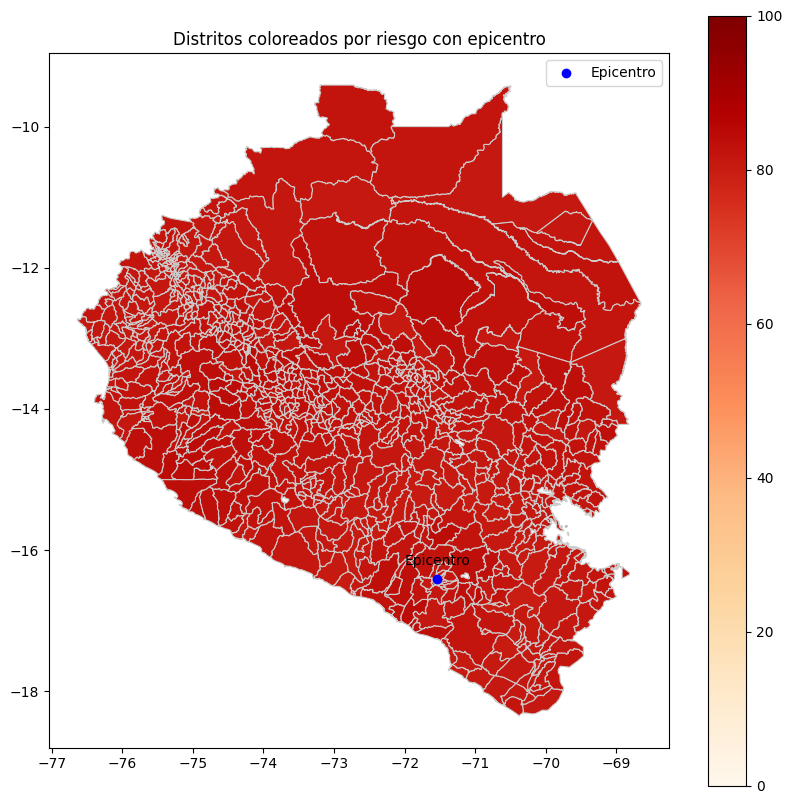

In [71]:
import geopandas as gpd
from matplotlib.colors import Normalize
distritos_en_area_efecto['geometry'] = distritos_en_area_efecto['Geo Shape'].apply(convert_geojson_to_geometry)

gdf = gpd.GeoDataFrame(distritos_en_area_efecto, geometry='geometry')

# Configurar la escala de color con un límite máximo de 100
norm = Normalize(vmin=0, vmax=100)

# Graficar los distritos y colorearlos según el riesgo
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='Riesgo', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, norm=norm)

# Graficar el epicentro
ax.scatter(epicentro_lon, epicentro_lat, color='blue', label='Epicentro', zorder=5)
ax.annotate('Epicentro', (epicentro_lon, epicentro_lat), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Distritos coloreados por riesgo con epicentro')
plt.legend()
plt.show()